How to add an environment to Jupyter Notebook:<br>
`
conda env list
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=EnvironmentName
`

What I have added in TrialEnv2:<br>
`
conda install python=3.10
conda install numpy
conda install -c conda-forge openbabel
conda install pandas
conda install -c conda-forge rdkit
conda install -c anaconda scikit-learn
`

In [1]:
#!conda install -y -c conda-forge openbabel
#Import files
import os
import warnings
import numpy as np
import keras
import keras.backend as K
from openbabel import pybel, openbabel
from sklearn.model_selection import train_test_split

from data import Featurizer, make_grid
from PUResNet import PUResNet
from train_functions import get_grids, get_training_data, DiceLoss

data_folder_path = "../../TrainData/train_test_families_1rep"

## Prepare the data

In [3]:
# To not see any warnings: pybel.ob.obErrorLog.StopLogging()
# To see warnings: pybel.ob.obErrorLog.StartLogging()

proteins, binding_sites, _ = get_training_data(data_folder_path)

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is 1d4o_NAP_1_protein)

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is 4hne_ADP_1_protein)

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is 1y6q_TDI_1_protein)



*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is 1w73_NAP_2_protein)



*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is 1ya8_MVB_1_protein)



KeyboardInterrupt: 

Download and upload the numpy arrays created:

In [4]:
# Download training data
np.save(data_folder_path+'_proteins.npy', proteins)
np.save(data_folder_path+'_binding_sites.npy', binding_sites)

In [8]:
# Upload training data
proteins = np.load(data_folder_path+'_proteins.npy')
binding_sites = np.load(data_folder_path+'_binding_sites.npy')

In [5]:
# Check that the two sets have the same number of training parameters
print(proteins.shape)
print(binding_sites.shape)

(1549, 36, 36, 36, 18)
(1549, 36, 36, 36, 1)


In [6]:
# Separate between train and test sets
X_train, X_test, y_train, y_test = train_test_split(proteins, 
                                                    binding_sites, 
                                                    test_size=0.2, 
                                                    random_state=42)

## Train the model

In [7]:
# I have based myself on this tutorial:
# https://keras.io/examples/vision/3D_image_classification/

## DEFINE VARIABLES ##
# In the paper, a batch size of 5 was used.
# They also found DiceLoss to be the best loss function to train the model
batch_size = 5
epochs = 300
loss_function = DiceLoss


## DEFINE CALLBACKS ##
# A Callback is an object that can perform actions at various stages of training
# ModelCheckpoint will save the best weights of the training
# EarlyStopping stops the training when val_loss stops improving
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=data_folder_path+"_best_weights.h5",
    monitor = "val_loss",
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=15)

## TRAIN THE MODEL ##
model = PUResNet()
model.compile(loss=loss_function, optimizer="adam", 
              metrics=["accuracy"])

model.fit(X_train, y_train, 
          batch_size=batch_size, epochs=epochs, 
          validation_split=0.1, shuffle=True,
          callbacks=[checkpoint_cb, early_stopping_cb])

2023-04-05 04:24:26.174037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 04:24:26.182600: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/300
223/223 [==============================] - 564s 2s/step - loss: 1.1962 - accuracy: 0.9795 - val_loss: 1.0030 - val_accuracy: 0.9968
Epoch 2/300
223/223 [==============================] - 558s 3s/step - loss: 0.8478 - accuracy: 0.9968 - val_loss: 0.9487 - val_accuracy: 0.9916
Epoch 3/300
223/223 [==============================] - 553s 2s/step - loss: 0.7191 - accuracy: 0.9970 - val_loss: 0.8362 - val_accuracy: 0.9928
Epoch 4/300
223/223 [==============================] - 557s 3s/step - loss: 0.6208 - accuracy: 0.9972 - val_loss: 0.7980 - val_accuracy: 0.9980
Epoch 5/300
223/223 [==============================] - 557s 2s/step - loss: 0.5590 - accuracy: 0.9973 - val_loss: 0.6475 - val_accuracy: 0.9976
Epoch 6/300
223/223 [==============================] - 554s 2s/step - loss: 0.5149 - accuracy: 0.9974 - val_loss: 0.6299 - val_accuracy: 0.9958
Epoch 7/300
223/223 [==============================] - 555s 2s/step - loss: 0.4673 - accuracy: 0.9975 - val_loss: 0.7648 - val_accuracy:

## Visualise the model

In [13]:
np.save(data_folder_path+'_accuracy.npy', model.history.history["accuracy"])
np.save(data_folder_path+'_val_loss.npy', model.history.history["val_loss"])

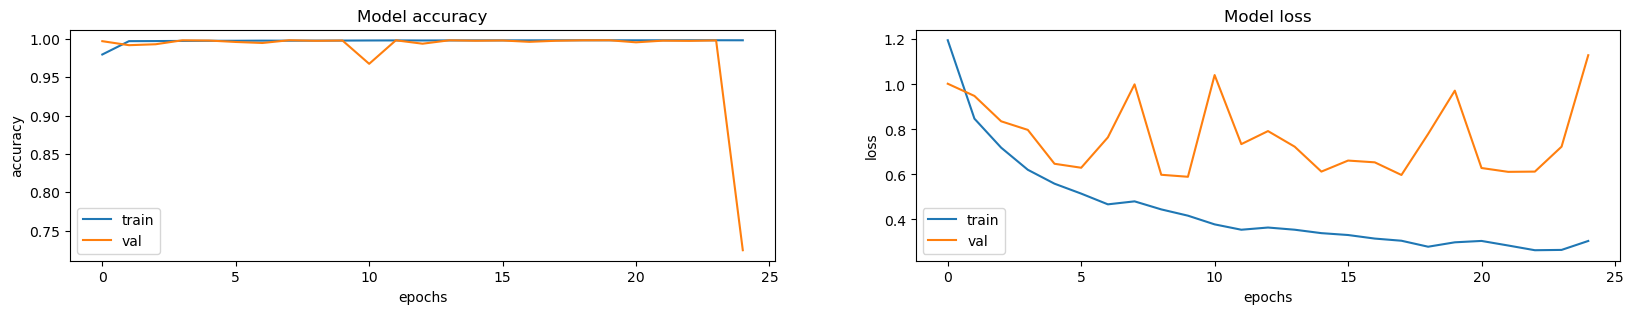

In [8]:
# Visualize the performance of the model
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
# Save into Data
plt.savefig(data_folder_path+'.png')

Info:
* train_test_subset_2000: trained with batch_size=5, early_stopping_cb="val_loss", patience = 15, trained during 25 epochs